This notebook was created after a suggestion by Niklas. The "automatic" optimiser failed to properly converge, so to test our aesthetic predictor models, we will try to manually generate the Layout and see if we can find any meaningful way to increase our score.

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import json
from math import prod
from huggingface_hub import hf_hub_download
import tqdm
transform_t_to_pil = T.ToPILImage()
transform_to_t = transforms.Compose([transforms.ToTensor()])
import utils
from utils import get_all_bounding_boxes, segment, calculate_initial_theta, stack_alpha_aware, AestheticPredictor
from lion_pytorch import Lion
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
appsthetics_predictor = torch.load("./resnet_50_20_epochs_2024-05-13T14:03")
appsthetics_predictor.eval()
1

FileNotFoundError: [Errno 2] No such file or directory: './resnet_50_20_epochs_2024-05-13T14:03'

In [12]:
im = Image.open('../combined/37910.jpg')
im = im.convert('RGBA')
im = im.resize((1440, 2560), Image.Resampling.LANCZOS)


with open("../combined/37910.json", "r") as f:
    image_json = json.load(f)

reduced_segments = [s for s in segment(im,image_json) if (prod(s[0].size) < 0.80*prod(im.size)) and (prod(s[0].size)>1)]
#even_more_reduced_segments = [reduced_segments[i] for i in [2,4,5,6,7,8,10,11,12]]

ValueError: num must be an integer with 1 <= num <= 18, not 19

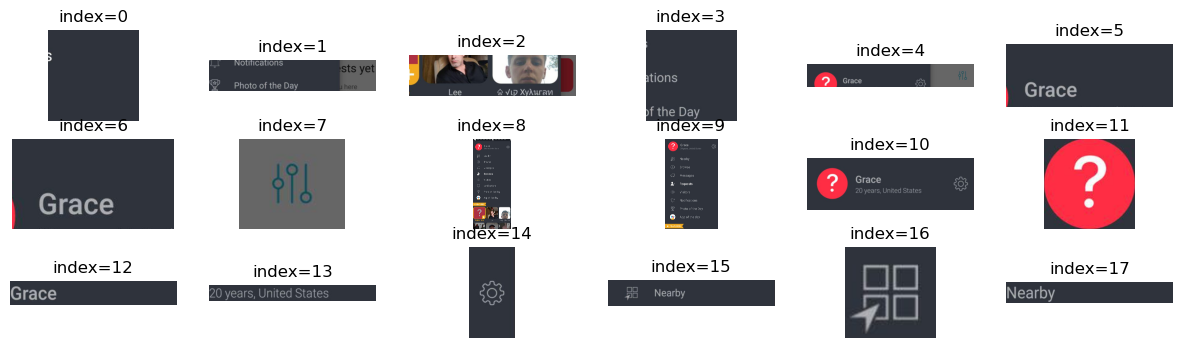

In [13]:
fig = plt.figure(figsize=(15, 4)) 
for n in range(len(reduced_segments)):
    fig.add_subplot(3, 6, n+1) 
    plt.imshow(reduced_segments[n][0])
    plt.title(f"index={n}")
    plt.axis("off")

In [4]:
aesthetic_predictor = AestheticPredictor()

In [15]:
segments_and_positions = even_more_reduced_segments
original_image_size = im.size
canvas_size = (1,3,original_image_size[1],original_image_size[0])

initial_vector = []
for segment,position in segments_and_positions:
    initial_theta = calculate_initial_theta(segment,original_image_size,position)
    initial_vector.append([initial_theta[0][2],initial_theta[1][2]])

coordinates = torch.tensor(initial_vector)

background_color = torch.tensor(np.array([1.0,1.0,1.0]))

def createUI(x_six=coordinates[6][0],y_six=coordinates[6][1], color="bla"):
    print(x_six, y_six)
    h = color.lstrip('#')
    print(h)
    rgb = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
    print('RGB =', rgb)
    background_color = torch.tensor(np.array([rgb[0]/255,rgb[1]/255,rgb[2]/255]))
    with torch.no_grad():
        segments_on_canvas = []
    
        # Create background image from parameter
        bg_col = torch.clamp(background_color, min=0, max=1)
        #print(f"Clamped bg to {bg_col}")
        red = torch.tile(bg_col[0],original_image_size[::-1])
        green = torch.tile(bg_col[1],original_image_size[::-1])
        blue = torch.tile(bg_col[2],original_image_size[::-1])
        alpha = torch.tile(torch.tensor(0.0),original_image_size[::-1])
        background = torch.stack([red,green,blue,alpha]).unsqueeze(0)
        #print(background.detach().sum())
        #background = torch.tile(self.background_color,self.original_image_size)
        
        
        for n in tqdm.tqdm(range(len(segments_and_positions))):
            # We need to calculate the proper ratios, to artificially warp the segment on to a bigger canvas without distorting it (see notebook 01)
            x_ratio = original_image_size[0] / segments_and_positions[n][0].size[0]
            y_ratio = original_image_size[1] / segments_and_positions[n][0].size[1]
            
            # Affine matrix
            theta = [
                [x_ratio, 0.0    , 0.0],
                [0.0    , y_ratio, 0.0]
            ]
            theta_tensor = torch.as_tensor(theta)[None]
            if n == 6:
                theta_tensor[0][0][2] += x_six
                theta_tensor[0][1][2] += y_six
            else:
                theta_tensor[0][0][2]+=coordinates[n][0]
                theta_tensor[0][1][2]+=coordinates[n][1]
            
            # Generate flow field
            grid = F.affine_grid(theta_tensor, canvas_size).type(torch.FloatTensor)
            x = F.grid_sample(transform_to_t(segments_and_positions[n][0]).unsqueeze(0), grid)
            segments_on_canvas.append(x)
    
        segments_on_canvas.append(background)
    
        generated_image = stack_alpha_aware(segments_on_canvas)
        # Remove Alpha channel
        generated_image = generated_image[:3]
    
        # score = aesthetic_predictor(generated_image.unsqueeze(0).float())
        score = appsthetics_predictor(generated_image.unsqueeze(0).float())
        
        plt.imshow(generated_image.detach().permute(1, 2, 0))
        plt.title(f'score={score.item()}')
        plt.show()

In [16]:
coordinates[6][1]

tensor(-10.5006, dtype=torch.float64)

In [17]:
slow = interactive(
    createUI, 
    {'manual': True},
    x_six=widgets.FloatSlider(value=float(coordinates[6][0].item()),min=-3.0, max=3.0, step=1e-4),
    y_six=widgets.FloatSlider(value=float(coordinates[6][1].item()),min=-15.0, max=15.0, step=1e-4),
    color = widgets.ColorPicker(
    concise=True,
    description='Pick a color',
    value='#ffffff',
    disabled=False
    )
) 

In [18]:
slow

interactive(children=(FloatSlider(value=-1.857836391437309, description='x_six', max=3.0, min=-3.0, step=0.000…